# Setup

In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Voting Classifiers

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

(np.float64(0.0), np.float64(10000.0), np.float64(0.42), np.float64(0.58))

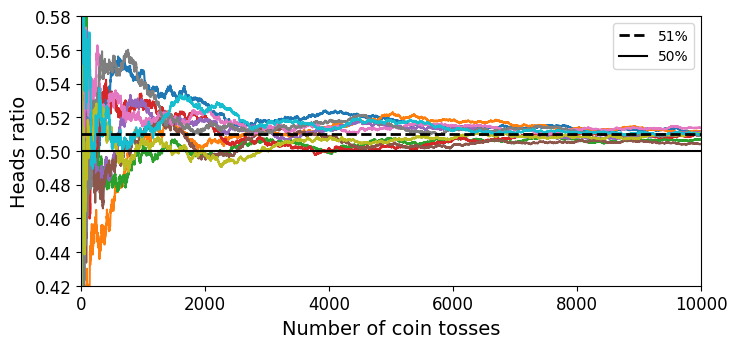

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.legend(loc='upper right')
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.axis([0,10000, 0.42, 0.58])

In [4]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=40)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=41)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('rf', rnd_clf),
        ('svc',svm_clf),
    ],
    voting='hard'
)
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=40)),
                             ('rf', RandomForestClassifier(random_state=41)),
                             ('svc', SVC(random_state=42))])

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.86
SVC 0.87
VotingClassifier 0.87


## Bagging and Pasting

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),n_estimators=500,bootstrap=True,random_state=42,max_samples=100,n_jobs=-1    
)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

In [8]:
accuracy_score(y_test,y_pred)

0.9

In [9]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.82


In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0],axes[1],100)
    x2s = np.linspace(axes[2],axes[3],100)
    x1, x2 = np.meshgrid(x1s,x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    if contour:
        custom_map = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_map, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

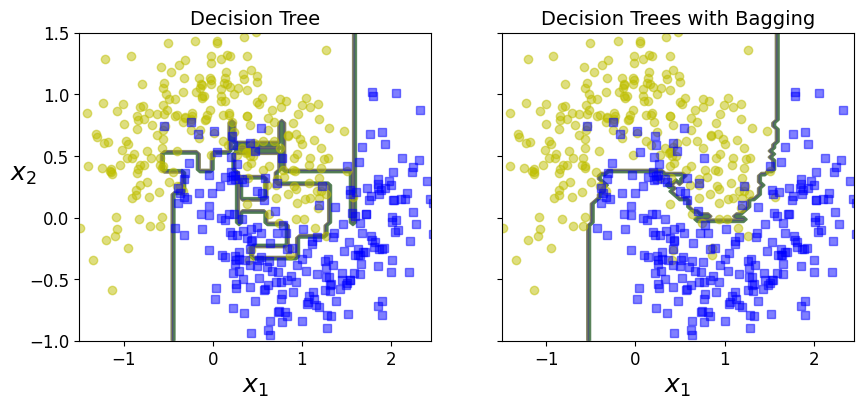

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

## Out-of-Bag Evolution

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.91

In [13]:
accuracy_score(y_test,(bag_clf.predict(X_test)))

0.88

In [14]:
bag_clf.oob_decision_function_

array([[0.99470899, 0.00529101],
       [0.        , 1.        ],
       [0.04812834, 0.95187166],
       [0.97109827, 0.02890173],
       [0.98907104, 0.01092896],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.62721893, 0.37278107],
       [0.51149425, 0.48850575],
       [0.        , 1.        ],
       [0.59638554, 0.40361446],
       [0.91794872, 0.08205128],
       [1.        , 0.        ],
       [0.00537634, 0.99462366],
       [0.45      , 0.55      ],
       [0.95789474, 0.04210526],
       [0.99441341, 0.00558659],
       [1.        , 0.        ],
       [0.99411765, 0.00588235],
       [0.03910615, 0.96089385],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.8079096 , 0.1920904 ],
       [1.        , 0.        ],
       [0.73184358, 0.26815642],
       [0.37244898, 0.62755102],
       [0.26436782, 0.73563218],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.

## Random Forests

In [15]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,random_state=41)
rnd_clf.fit(X_train,y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [16]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(
    max_features="sqrt", max_leaf_nodes=16),n_estimators=500,random_state=41)
bag_clf.fit(X_train,y_train)
y_pred_bag = bag_clf.predict(X_test)

In [17]:
np.sum(y_pred_bag == y_pred_rf) / len(y_pred_bag)

np.float64(1.0)

### Feature Importance

In [18]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(iris["data"],iris["target"])
for name, score in zip(iris["feature_names"],rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.0966148014005634
sepal width (cm) 0.022743706267821087
petal length (cm) 0.4443739304222949
petal width (cm) 0.43626756190932064


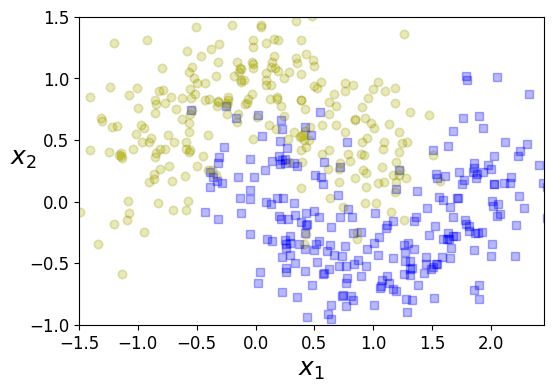

In [19]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

In [20]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [21]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [22]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image,cmap=mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

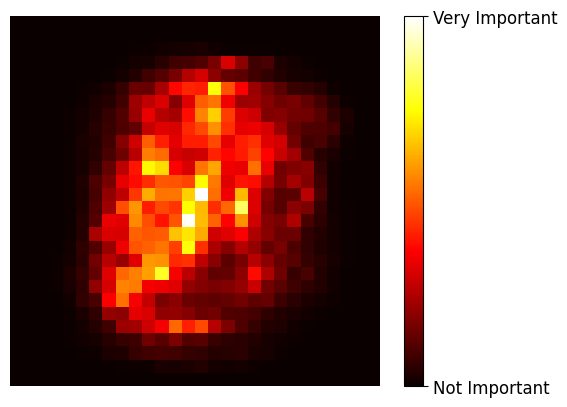

In [23]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not Important', "Very Important"])
plt.show()

## Boosting

### AdaBoosting

In [24]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),n_estimators=200,algorithm="SAMME",random_state=41,learning_rate=0.5
)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=41)

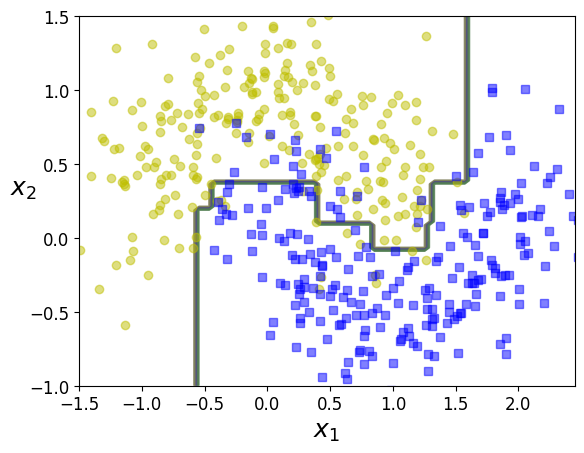

In [25]:
plot_decision_boundary(ada_clf,X,y)

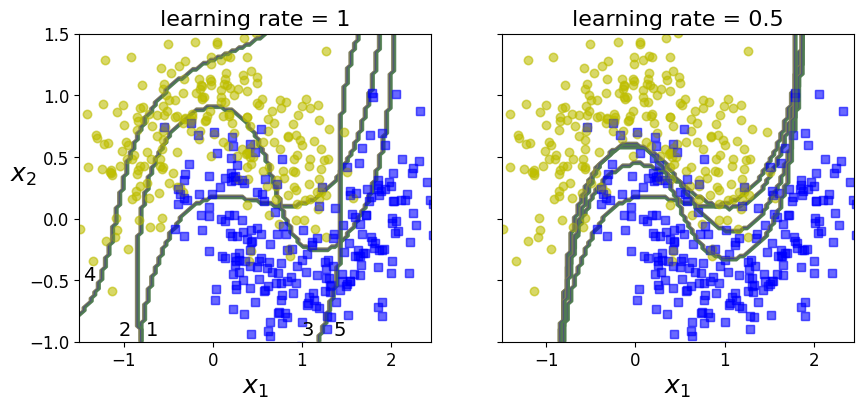

In [26]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0,1),(1, 0.5)):
    sample_weights = np.ones(m)/m
    plt.sca(axes[subplot])
    for i in range(4):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train,y_train, sample_weight= sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
        alpha = learning_rate * np.log((1-r) / r)
        sample_weights[y_pred != y_train] *=  np.exp(alpha)
        sample_weights /= sample_weights.sum()

        plot_decision_boundary(svm_clf,X, y, alpha=0.2)
        plt.title("learning rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")
plt.show()

## Gradient Boosting

In [27]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [28]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [29]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [30]:
y3 = y2 - tree_reg1.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [31]:
X_new = np.array([[0.8]])

In [32]:
y_pred = sum((tree.predict(X_new)) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.03991297])

In [33]:
def plot_predictions(regressors, X, y, axes, label=None, style='r-', data_style="b.",data_label=None):
    x1 = np.linspace(axes[0],axes[1],500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:,0],y, data_style,label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2,label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

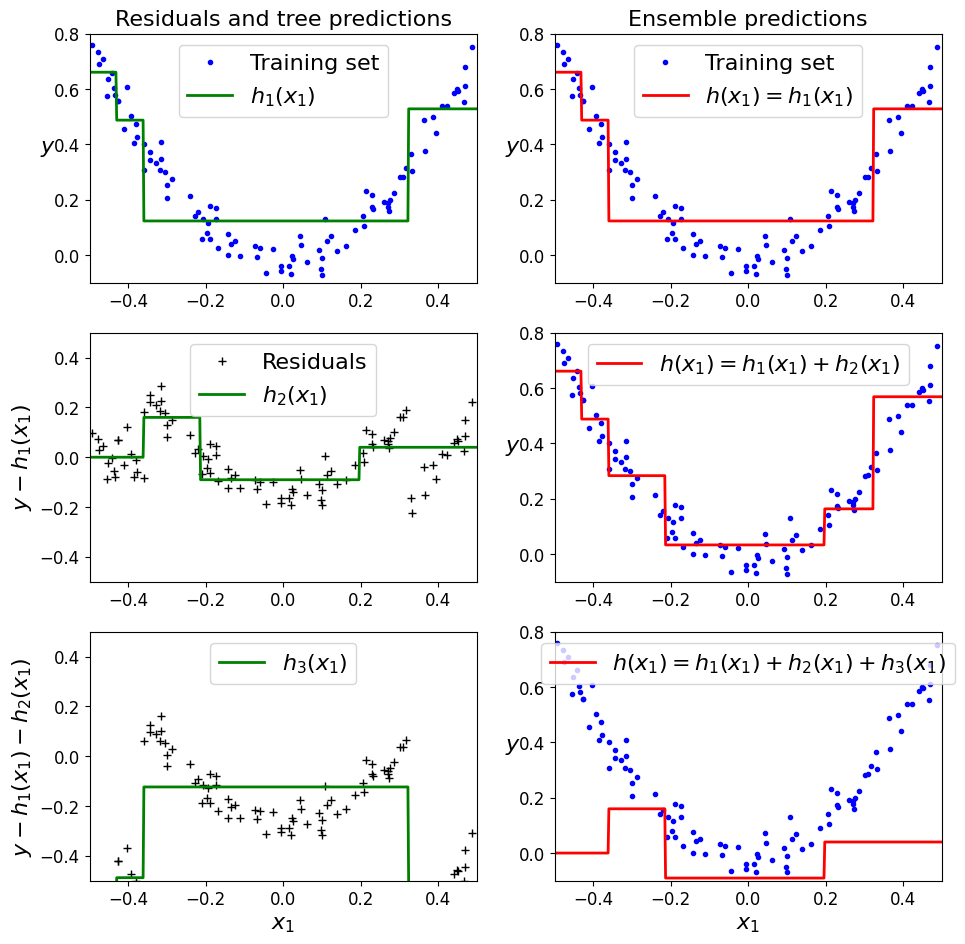

In [34]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [36]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=300, learning_rate=0.1,random_state=42)
gbrt_slow.fit(X,y)

GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=42)

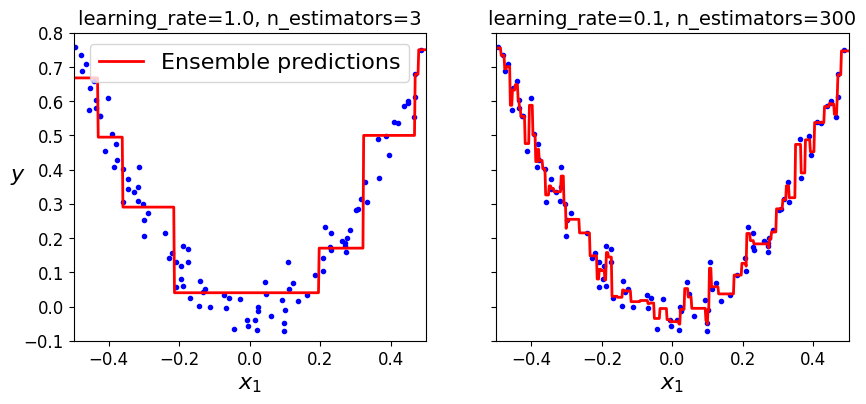

In [37]:
fix, axes = plt.subplots(ncols=2,figsize=(10,4),sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

#### Gradient Boosting with Early stopping:


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120,random_state=42)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val,y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(56),
                          random_state=42)

In [39]:
min_error = np.min(errors)

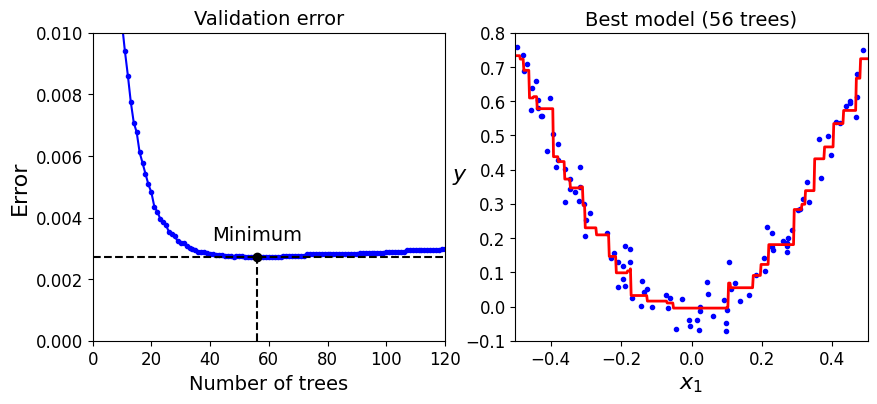

In [40]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

In [41]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [42]:
print(gbrt.n_estimators_)

61


In [43]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


### Using XGBoost:


In [44]:
import xgboost

In [45]:
xbg_reg = xgboost.XGBRegressor(random_state=42)
xbg_reg.fit(X_train,y_train)
y_pred = xbg_reg.predict(X_val)
val_error = mean_squared_error(y_val,y_pred)
print("Validation MSE:",val_error)

Validation MSE: 0.004644479346317078


In [46]:
xbg_reg = xgboost.XGBRegressor(random_state=42)
xbg_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)])
y_pred = xbg_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)  # Not shown
print("Validation MSE:", val_error) 

[0]	validation_0-rmse:0.15232
[1]	validation_0-rmse:0.10690
[2]	validation_0-rmse:0.07868
[3]	validation_0-rmse:0.06385
[4]	validation_0-rmse:0.05656
[5]	validation_0-rmse:0.05486
[6]	validation_0-rmse:0.05394
[7]	validation_0-rmse:0.05556
[8]	validation_0-rmse:0.05682
[9]	validation_0-rmse:0.05811
[10]	validation_0-rmse:0.05983
[11]	validation_0-rmse:0.06033
[12]	validation_0-rmse:0.06100
[13]	validation_0-rmse:0.06179
[14]	validation_0-rmse:0.06206
[15]	validation_0-rmse:0.06235
[16]	validation_0-rmse:0.06230
[17]	validation_0-rmse:0.06272
[18]	validation_0-rmse:0.06281
[19]	validation_0-rmse:0.06308
[20]	validation_0-rmse:0.06294
[21]	validation_0-rmse:0.06299
[22]	validation_0-rmse:0.06281
[23]	validation_0-rmse:0.06325
[24]	validation_0-rmse:0.06369
[25]	validation_0-rmse:0.06358
[26]	validation_0-rmse:0.06395
[27]	validation_0-rmse:0.06394
[28]	validation_0-rmse:0.06429
[29]	validation_0-rmse:0.06447
[30]	validation_0-rmse:0.06471
[31]	validation_0-rmse:0.06500
[32]	validation_0-

### Voting Classifier on MNIST

In [48]:
X_train_val,X_test,y_train_val,y_test = train_test_split(mnist.data,int(mnist.target),test_size=10000,random_state=41)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=10000,random_state=41)

In [49]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

rnd_clf = RandomForestClassifier(random_state=41,n_estimators=100)
extra_tree = ExtraTreesClassifier(n_estimators=100,random_state=41)
lin_svc = LinearSVC(max_iter=100, tol=20, random_state=41)
mlp_clf = MLPClassifier(random_state=41)

In [50]:
estimators = [rnd_clf,extra_tree,lin_svc,mlp_clf]
for estimator in estimators:
    print("Traning the: ",estimator)
    estimator.fit(X_train,y_train)

Traning the:  RandomForestClassifier(random_state=41)
Traning the:  ExtraTreesClassifier(random_state=41)
Traning the:  LinearSVC(max_iter=100, random_state=41, tol=20)
Traning the:  MLPClassifier(random_state=41)


In [53]:
[estimator.score(X_val,y_val) for estimator in estimators]

[0.9666, 0.9686, 0.1011, 0.9551]

In [56]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier([
    ('random_clf',rnd_clf),
    ('extra_tree',extra_tree),
    ('lin_svc',lin_svc),
    ('mlp_clf',mlp_clf),
])

In [57]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('random_clf',
                              RandomForestClassifier(random_state=41)),
                             ('extra_tree',
                              ExtraTreesClassifier(random_state=41)),
                             ('lin_svc',
                              LinearSVC(max_iter=100, random_state=41, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=41))])

In [58]:
voting_clf.score(X_val,y_val)

0.9681

In [59]:
voting_clf.set_params(lin_svc=None)

VotingClassifier(estimators=[('random_clf',
                              RandomForestClassifier(random_state=41)),
                             ('extra_tree',
                              ExtraTreesClassifier(random_state=41)),
                             ('lin_svc', None),
                             ('mlp_clf', MLPClassifier(random_state=41))])

In [60]:
voting_clf.estimators

[('random_clf', RandomForestClassifier(random_state=41)),
 ('extra_tree', ExtraTreesClassifier(random_state=41)),
 ('lin_svc', None),
 ('mlp_clf', MLPClassifier(random_state=41))]

In [63]:
del voting_clf.estimators_[2]

In [64]:
voting_clf.estimators_

[RandomForestClassifier(random_state=41),
 ExtraTreesClassifier(random_state=41),
 MLPClassifier(random_state=41)]

In [66]:
voting_clf.score(X_val,y_val)

0.9697

In [67]:
voting_clf.voting = "soft"

In [68]:
voting_clf.score(X_val,y_val)

0.9654

In [69]:
voting_clf.voting = "hard"

In [71]:
voting_clf.score(X_test,y_test)

0.9699

In [72]:
[estimator.score(X_test,y_test) for  estimator in estimators]

[0.9649, 0.9688, 0.0908, 0.9589]

### Stacking Ensemble

In [76]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)
for index, estimator in enumerate(estimators):
    X_val_predictions[:,index] = estimator.predict(X_val) 

In [83]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200,random_state=41,oob_score = True)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=41)

In [85]:
rnd_forest_blender.oob_score_

0.9672

In [86]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)
for index, estimator in enumerate(estimators):
    X_test_predictions[:,index] = estimator.predict(X_test)

In [88]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [89]:
accuracy_score(y_test, y_pred)

0.9695